In [107]:
import pandas as pd
from binance.client import Client
import backtrader as bt
import matplotlib.pyplot as plt
import mplfinance as mpf
import itertools
import numpy as np
import seaborn as sns
%matplotlib inline

### Premise on the workflow
This workflow is designed to closely follow my thought process. At points where the code is modified from earlier versions, I explain the reasons behind the changes, including any mistakes identified and the rationale for improvements. This approach aims to provide transparency into the development and analysis steps, helping the reader understand why certain adjustments were made. At points it might have been better to simply rewrite the old code, but this would miss the thinking process.

## Simple strategy
# SMA Crossover Strategy – Algorithm Development Plan

## 1. Environment Setup  
Set up the Python environment with all necessary libraries for strategy development, backtesting, and performance analysis:  
- `backtrader`  
- `pandas`  
- `matplotlib`  
- `numpy` (optional for optimization)


## 2. Strategy Implementation  
Implement the core logic of the SMA Crossover strategy:  
- Define short-term and long-term SMAs  
- Generate **buy signals** when the short SMA crosses above the long SMA  
- Generate **sell signals** when the short SMA crosses below the long SMA  


## 3. Backtesting Engine  
Use historical data to simulate the strategy’s past performance:  
- Fetch historical stock/crypto data  
- Integrate with Backtrader’s backtesting framework  
- Simulate trades based on defined logic


## 4. Performance Analysis  
Evaluate the strategy using key performance metrics:  
-  Sharpe Ratio  
-  Maximum Drawdown  
-  Total Return  
-  Win Rate  


## 5. Visualization  
Create visual tools to interpret and present results:  
- Price chart with buy/sell markers  
- Strategy equity curve  
- Overlay of SMAs and signals on price chart  


## 6. Parameter Optimization  
Test various SMA combinations (e.g. 10/50, 20/100):  
- Use grid search or loops  
- Compare results across different timeframes and assets  
- Identify optimal values for maximizing Sharpe ratio or return  


## 7. Conclusion and Insights  
Summarize key observations and reflect on:  
- Strategy strengths and weaknesses  
- Conditions where it performs well or poorly  
- Ideas for future improvements (e.g. adding volume filters, trailing stops, risk management)


Let me know if you'd like this turned into a project template or notebook starter!


We will start small. We are going to begin by implementing a very basic momentum trading strategy and then go ahead from there.
- If the price has gone up a lot over the last $N$ days, we buy
- If the price has dropped over the last $N$ days, we sel

For this purpose we are going to use ```backtrader```


We are going to create a ```MomentumStrategy``` class where we we calculate the momentum over the last ```lookback``` days using the formula: $$
\text{Momentum}_t = \frac{P_t - P_{t - L}}{P_{t - L}} = \frac{P_t}{P_{t - L}} - 1
$$

In [81]:
class MomentumStrategy(bt.Strategy):
    params = (
        ('lookback', 20),       
        ('threshold', 0.01),     
        ('trade_size', 0.1),     
    )

    def next(self):
        if len(self.data) < self.p.lookback:
            return  # not enough data yet
    
        momentum = (self.data.close[0] / self.data.close[-self.p.lookback]) - 1
        size = (self.broker.getvalue() * self.p.trade_size) / self.data.close[0] #I converted this to int but it was not appropriate for bitcoin since the value is always lower than 1 when buying
       
        # SELL condition
        if momentum < -self.p.threshold and self.position.size > 0:
            
            self.close()

        # BUY condition
        elif momentum > self.p.threshold and not self.position:
            if size > 0:
               
                self.buy(size=size)
            else:
                print("Calculated size too small to buy")



We start by defining key parameters such as lookback, threshold, and trade_size. The momentum is calculated using these parameters based on historical price data.

- In the ```next``` method, we first check if we have enough data to calculate momentum. Once we have enough information, we compute the momentum value.

- If the momentum falls below the negative threshold and we currently hold a position, we sell to exit the trade.

Conversely, if the momentum rises above the positive threshold and we do not hold any position, we buy a calculated amount of shares based on our portfolio size and the **trade_size** parameter.

### Doing backtesting on the small engine

For the purpose of backtesting I am going to use "Cerebro engine". Before doing that I will run ```pip install python-binance``` to get access to information about the market.

In [82]:
from binance.client import Client
import pandas as pd

# We will need no API key since the data is public
client = Client()

# Fetch historical klines (candles) for BTCUSDT, 1h interval, last 1000 candles
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "1000 hours ago UTC")

# Convert to DataFrame and select columns
df = pd.DataFrame(klines, columns=[
    'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Close time', 'Quote asset volume', 'Number of trades',
    'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])

# Convert timestamps to datetime
df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')

# Keep only useful columns for backtesting
df = df[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Convert columns to float
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)

# Set 'Open time' as the datetime index for mplfinance compatibility
df.set_index('Open time', inplace=True)

print(df.head())


                          Open       High        Low      Close      Volume
Open time                                                                  
2025-05-28 15:00:00  107522.71  107677.28  107045.45  107107.31  2226.89421
2025-05-28 16:00:00  107107.31  107457.59  107107.31  107420.00   629.26184
2025-05-28 17:00:00  107420.00  107832.38  107363.63  107679.01   886.65781
2025-05-28 18:00:00  107679.01  107842.29  107388.00  107476.55   436.15460
2025-05-28 19:00:00  107476.54  107798.14  106938.24  106946.01   805.61276


In [83]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

Now that we have our data that we are going to work with we can plot it to see how it looks like.

C:\Users\mitko\AppData\Local\Programs\Python\Python310\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


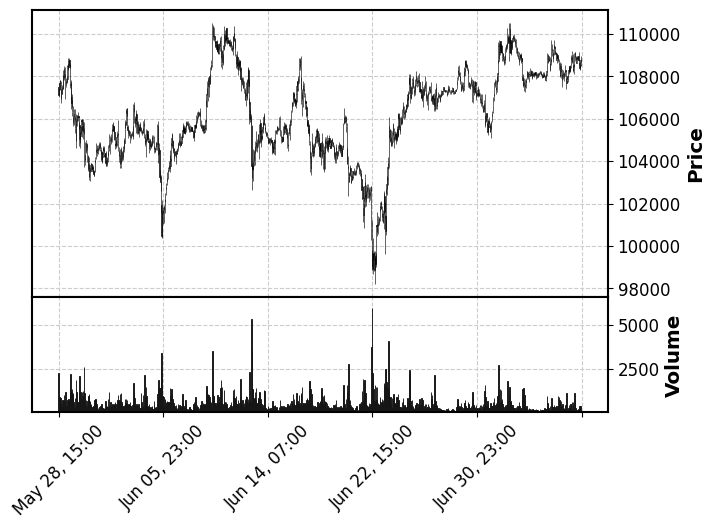

In [84]:

mpf.plot(df, type='candle', volume=True, style='classic')

plt.show()

Now that we can visually see we can go forward and try to do simple backtesting. Before that I will rename the columns for conviniency.

In [85]:
df.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)

Let us create a datafeed.

In [86]:
datafeed = bt.feeds.PandasData(dataname=df)

In [87]:
INITIAL_CASH = 10000
cerebro = bt.Cerebro()

cerebro.addstrategy(MomentumStrategy, lookback=20, threshold=0.02, trade_size=0.1) # We also can adjust the params here.

cerebro.adddata(datafeed)

cerebro.broker.setcash(INITIAL_CASH)

# I am not going to set commission since we assume that we are trading in a firm and have no commissions.
# cerebro.broker.set_fundmode(True)
results = cerebro.run()

In [88]:
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")

Final Portfolio Value: 10037.22


I want to notice that I used to get a value 10000 for the portfolio. Therefore no trades were made. We have not bought, our position stays at zero, we can not sell. Where is this problem coming from? After some observation we can notice that we are using ```size = int((self.broker.getvalue() * self.p.trade_size) / close_price)``` which returns 0 if the value is less than 0. Since we are buyin Bitcoins, we are never buying more than 1 bitcoin at a time. After removing the parsing to int the problem is no longer there.

Okey, we got a result and we see that we have increased our portfolio with 37 dollars, which is about 0.37%. It is a possitive increase but not hing impresive. Let us analyze some more this result before moving to improvements.

In [89]:
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe', timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

In [90]:
results = cerebro.run()
strat = results[0]


In [91]:

trade_stats = strat.analyzers.trades.get_analysis()

# Total trades
total_trades = trade_stats.total.total
open_trades = trade_stats.total.open
closed_trades = trade_stats.total.closed

# Wins and losses
won = trade_stats.won.total
lost = trade_stats.lost.total

# PnL
total_net_pnl = trade_stats.pnl.net.total
average_net_pnl = trade_stats.pnl.net.average

print(f"Total trades: {total_trades}")
print(f"Open trades: {open_trades}")
print(f"Closed trades: {closed_trades}")
print(f"Winning trades: {won}")
print(f"Losing trades: {lost}")
print(f"Total Net PnL: {total_net_pnl:.2f}")
print(f"Average Net PnL: {average_net_pnl:.2f}")

Total trades: 4
Open trades: 0
Closed trades: 4
Winning trades: 2
Losing trades: 2
Total Net PnL: 37.22
Average Net PnL: 9.30


In [92]:
sharpe = strat.analyzers.sharpe.get_analysis()
drawdown = strat.analyzers.drawdown.get_analysis()

print("Sharpe Ratio:", sharpe.get('sharperatio', 'N/A'))
print(f"Max Drawdown: {drawdown.drawdown:.2f}%")
print(f"Drawdown Duration: {drawdown.len} bars")

Sharpe Ratio: 0.5823840575651847
Max Drawdown: 0.26%
Drawdown Duration: 137 bars


### Improving the simple model
Based on the information above, we can conclude that our model functions but is far from optimal. Next, we will work on making it more complex and improving its performance. The first thing that might come to mind is how we actually decide on the hyperparameters we are using such as the threshhold and the trade size. There are a couple approaches when it comes to choosing those:


- **Grid Search**  
  Try all combinations of discrete values

- **Random Search**  
  Randomly sample combinations from the hyperparameter space

- **Bayesian Optimization**  
  Use prior evaluations to guide the search (e.g., maximize Sharpe ratio)

- **Walk-Forward Optimization**  
  1. Train on time window $$[t, t+k]$$  
  2. Test on $$[t+k+1, t+2k]$$  
  3. Slide the window forward


Before implementing GridSearch, we should ensure that the parameter values are not chosen arbitrarily, but are instead grounded in reasonable assumptions and sound trading principles. For instance, a trade size of 0.3 or 0.4 is clearly unreasonable, as it allocates a disproportionately large portion of the capital to a single trade, which significantly increases risk.

In [93]:
class BinanceData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', -1),
    )
lookbacks = [10, 20, 50]
thresholds = [0.005, 0.01, 0.02]
trade_sizes = np.arange(0.01,0.1,0.01)

results = []

for lookback, threshold, trade_size in itertools.product(lookbacks, thresholds, trade_sizes):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MomentumStrategy,
                        lookback=lookback,
                        threshold=threshold,
                        trade_size=trade_size)
    
    data = BinanceData(dataname=df)
    cerebro.adddata(data)

    cerebro.broker.setcash(10000)
    cerebro.broker.setcommission(commission=0)
    cerebro.run()

    final_value = cerebro.broker.getvalue()
    results.append({
        'lookback': lookback,
        'threshold': threshold,
        'trade_size': trade_size,
        'final_value': final_value
    })
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='final_value', ascending=False)

print(" Top Results:")
print(results_df.head())

 Top Results:
    lookback  threshold  trade_size   final_value
17        10       0.01        0.09  10036.662324
53        20       0.02        0.09  10033.517449
16        10       0.01        0.08  10032.603494
52        20       0.02        0.08  10029.812537
15        10       0.01        0.07  10028.540969


If we make the trade size bigger we will notice that we can increase the final value, however this comes with a lot of risk. For now we will leave that and do something else. **Our model is still extremely simply and we are going to make it a bit more complex.** I am going to try and implement a **SMA crossover.** For this purpose I will
- Define short-term and long-term SMAs  
- Generate **buy signals** when the short SMA crosses above the long SMA  
- Generate **sell signals** when the short SMA crosses below the long SMA

Let's add this to our model.

In [94]:
import backtrader as bt

class MomentumStrategyWithSMA(bt.Strategy):
    params = (
        ('lookback', 20),
        ('threshold', 0.01),
        ('trade_size', 0.1),
        ('sma_fast_period', 10),  # short-term SMA
        ('sma_slow_period', 30),  # long-term SMA
    )
    
    def __init__(self):
        self.sma_fast = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_fast_period)
        self.sma_slow = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_slow_period)
        self.crossover = bt.indicators.CrossOver(self.sma_fast, self.sma_slow)  # +1 when fast crosses above slow, -1 when below
    
    def next(self):
        if len(self.data) < max(self.p.lookback, self.p.sma_slow_period):
            return  # wait until enough data

        momentum = (self.data.close[0] / self.data.close[-self.p.lookback]) - 1
        size = (self.broker.getvalue() * self.p.trade_size) / self.data.close[0]

        # SELL condition: momentum < -threshold AND fast SMA crosses below slow SMA
        if momentum < -self.p.threshold and self.position.size > 0 and self.crossover < 0:
            self.close()

        # BUY condition: momentum > threshold AND fast SMA crosses above slow SMA
        elif momentum > self.p.threshold and not self.position and self.crossover > 0:
            if size > 0:
                self.buy(size=size)
            else:
                print("Calculated size too small to buy")


In [95]:
def run_backtest(strategy_class, **strategy_params):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class, **strategy_params)
    cerebro.adddata(datafeed)
    cerebro.broker.setcash(INITIAL_CASH)
    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe', timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    results = cerebro.run()
    strat = results[0]

    trade_stats = strat.analyzers.trades.get_analysis()
    sharpe = strat.analyzers.sharpe.get_analysis()
    drawdown = strat.analyzers.drawdown.get_analysis()

    total_trades = trade_stats.get('total', {}).get('total', 0)
    won = trade_stats.get('won', {}).get('total', 0)
    lost = trade_stats.get('lost', {}).get('total', 0)
    pnl_total = trade_stats.get('pnl', {}).get('net', {}).get('total', 0)
    pnl_avg = trade_stats.get('pnl', {}).get('net', {}).get('average', 0)
    
    print(f"Strategy: {strategy_class.__name__}")
    print(f"Total trades: {total_trades}")
    print(f"Winning trades: {won}")
    print(f"Losing trades: {lost}")
    print(f"Total Net PnL: {pnl_total:.2f}")
    print(f"Average Net PnL: {pnl_avg:.2f}")
    print("Sharpe Ratio:", sharpe.get('sharperatio', 'N/A'))
    print(f"Max Drawdown: {drawdown.drawdown:.2f}%")
    print(f"Drawdown Duration: {drawdown.len} bars")
    print("===================================")


In [105]:
run_backtest(MomentumStrategy, lookback=20, threshold=0.01, trade_size=0.1)
run_backtest(MomentumStrategyWithSMA, lookback=20, threshold=0.01, trade_size=0.1, sma_fast_period=10, sma_slow_period=50)



Strategy: MomentumStrategy
Total trades: 12
Winning trades: 3
Losing trades: 8
Total Net PnL: 6.12
Average Net PnL: 0.56
Sharpe Ratio: -0.40803184543265725
Max Drawdown: 0.26%
Drawdown Duration: 137 bars
Strategy: MomentumStrategyWithSMA
Total trades: 2
Winning trades: 2
Losing trades: 0
Total Net PnL: 78.24
Average Net PnL: 39.12
Sharpe Ratio: 1.8587250313980614
Max Drawdown: 0.12%
Drawdown Duration: 137 bars


In [99]:
import itertools
import numpy as np
import pandas as pd

lookbacks = [10, 20, 50]
thresholds = [0.01, 0.02]  # fewer thresholds
trade_sizes = [0.01, 0.05, 0.1]  # fewer trade sizes
sma_fast_periods = [5, 10]
sma_slow_periods = [20, 30, 50]

results = []

total_runs = 0
for lookback, threshold, trade_size, sma_fast, sma_slow in itertools.product(
    lookbacks, thresholds, trade_sizes, sma_fast_periods, sma_slow_periods):

    if sma_fast >= sma_slow:
        continue

    total_runs += 1

print(f"Total backtests to run: {total_runs}")

for i, (lookback, threshold, trade_size, sma_fast, sma_slow) in enumerate(itertools.product(
    lookbacks, thresholds, trade_sizes, sma_fast_periods, sma_slow_periods)):

    if sma_fast >= sma_slow:
        continue

    # Optional: print progress every 10 runs
    if i % 10 == 0:
        print(f"Running backtest {i+1}/{total_runs}")

    cerebro = bt.Cerebro()
    cerebro.addstrategy(MomentumStrategyWithSMA,
                        lookback=lookback,
                        threshold=threshold,
                        trade_size=trade_size,
                        sma_fast_period=sma_fast,
                        sma_slow_period=sma_slow)

    data = BinanceData(dataname=df)
    cerebro.adddata(data)

    cerebro.broker.setcash(10000)
    cerebro.broker.setcommission(commission=0.001)

    cerebro.run()
    final_value = cerebro.broker.getvalue()

    results.append({
        'lookback': lookback,
        'threshold': threshold,
        'trade_size': trade_size,
        'sma_fast': sma_fast,
        'sma_slow': sma_slow,
        'final_value': final_value
    })

results_df = pd.DataFrame(results).sort_values(by='final_value', ascending=False)


Total backtests to run: 108
Running backtest 1/108
Running backtest 11/108
Running backtest 21/108
Running backtest 31/108
Running backtest 41/108
Running backtest 51/108
Running backtest 61/108
Running backtest 71/108
Running backtest 81/108
Running backtest 91/108
Running backtest 101/108
Top results with SMA:
    lookback  threshold  trade_size  sma_fast  sma_slow   final_value
53        20       0.01         0.1        10        50  10074.142538
71        20       0.02         0.1        10        50  10072.433346
68        20       0.02         0.1         5        50  10070.920821
50        20       0.01         0.1         5        50  10067.247798
31        10       0.02         0.1         5        30  10067.231212


NameError: name 'top_5' is not defined

Now we can see how our new model performs with different hyperparameters. We see that there are lots of cases where we get a positive final_value but there is also one important thing missing and it is information about the trades made. This is imprtant since we cannot rely on algorithms that have simply performed little to none trades that turned out to be lucky. Let's check some more statistics.

In [101]:
top_5 = results_df.head(5)
print("Top results with SMA:")
print(results_df.head())
for _, row in top_5.iterrows():
    if 'sma_fast' in row and not pd.isna(row['sma_fast']):
        run_backtest(MomentumStrategyWithSMA,
                     lookback=int(row['lookback']),
                     threshold=row['threshold'],
                     trade_size=row['trade_size'],
                     sma_fast_period=int(row['sma_fast']),
                     sma_slow_period=int(row['sma_slow']))
    else:
        run_backtest(MomentumStrategy,
                     lookback=int(row['lookback']),
                     threshold=row['threshold'],
                     trade_size=row['trade_size'])

Top results with SMA:
    lookback  threshold  trade_size  sma_fast  sma_slow   final_value
53        20       0.01         0.1        10        50  10074.142538
71        20       0.02         0.1        10        50  10072.433346
68        20       0.02         0.1         5        50  10070.920821
50        20       0.01         0.1         5        50  10067.247798
31        10       0.02         0.1         5        30  10067.231212
Strategy: MomentumStrategyWithSMA
Total trades: 2
Winning trades: 2
Losing trades: 0
Total Net PnL: 78.24
Average Net PnL: 39.12
Sharpe Ratio: 1.8587250313980614
Max Drawdown: 0.12%
Drawdown Duration: 137 bars
Strategy: MomentumStrategyWithSMA
Total trades: 2
Winning trades: 1
Losing trades: 0
Total Net PnL: 5.64
Average Net PnL: 5.64
Sharpe Ratio: 1.7157446808753127
Max Drawdown: 0.15%
Drawdown Duration: 137 bars
Strategy: MomentumStrategyWithSMA
Total trades: 1
Winning trades: 0
Losing trades: 0
Total Net PnL: 0.00
Average Net PnL: 0.00
Sharpe Ratio:

The insights we get from that are extremely valiable. 
- Firstly we execute little to no trades. This means that the information could be missleading.
- Secondly, although the sharpe ration is good, we have not met one of the **assumptions** it has - following a normal distribuution.

Probably the best thing we could do right now is to try and extend the period of our data since we are only using the last 1000 hours.

In [113]:
from binance.client import Client
import pandas as pd
import time
from datetime import datetime, timedelta

# No API key needed for public data
client = Client()

# Function to fetch hourly data for up to 3 years
def fetch_hourly_data(symbol="BTCUSDT", years=3):
    interval = Client.KLINE_INTERVAL_1HOUR
    end_time = datetime.utcnow()
    start_time = end_time - timedelta(days=365 * years)
    
    df_list = []
    while start_time < end_time:
        # Convert to string
        start_str = start_time.strftime("%d %b %Y %H:%M:%S")
        try:
            klines = client.get_historical_klines(symbol, interval, start_str, limit=1000)
            if not klines:
                break
            
            temp_df = pd.DataFrame(klines, columns=[
                'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
                'Close time', 'Quote asset volume', 'Number of trades',
                'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])

            temp_df['Open time'] = pd.to_datetime(temp_df['Open time'], unit='ms')
            temp_df['Close time'] = pd.to_datetime(temp_df['Close time'], unit='ms')
            temp_df = temp_df[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
            temp_df[['Open', 'High', 'Low', 'Close', 'Volume']] = temp_df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
            df_list.append(temp_df)

            # Step forward 1000 hours
            start_time = temp_df['Open time'].iloc[-1] + timedelta(hours=1)
            time.sleep(0.5)  # Respect API rate limits
        except Exception as e:
            print("Error:", e)
            time.sleep(1)
    
    full_df = pd.concat(df_list).set_index('Open time')
    return full_df

# Fetch 3 years of data
df = fetch_hourly_data(years=3)

print(df.head())
print(df.tail())
print(f"Total candles: {len(df)}")


                         Open      High       Low     Close      Volume
Open time                                                              
2022-07-10 07:00:00  21297.28  21360.58  21245.15  21338.12  6558.20641
2022-07-10 08:00:00  21339.46  21424.67  21255.25  21324.16  7891.41116
2022-07-10 09:00:00  21325.36  21361.52  21286.00  21325.00  6132.31280
2022-07-10 10:00:00  21326.13  21355.85  21220.53  21277.09  7750.73745
2022-07-10 11:00:00  21277.09  21304.96  21161.67  21301.84  8215.91876
                          Open       High        Low      Close     Volume
Open time                                                                 
2025-07-09 02:00:00  108780.77  108837.70  108600.00  108611.53  277.87433
2025-07-09 03:00:00  108611.53  108665.40  108348.00  108376.41  356.48997
2025-07-09 04:00:00  108376.41  108564.00  108324.53  108553.61  214.96856
2025-07-09 05:00:00  108553.60  108942.20  108489.20  108778.10  393.65608
2025-07-09 06:00:00  108778.10  108836.38  108

C:\Users\mitko\AppData\Local\Programs\Python\Python310\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


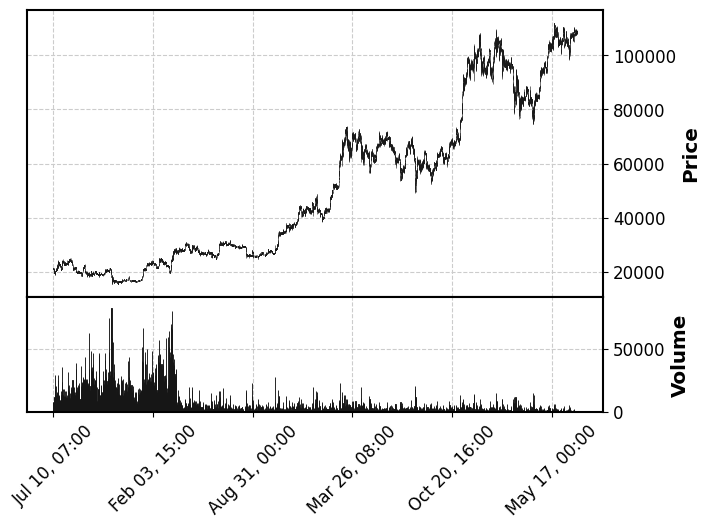

In [114]:

mpf.plot(df, type='candle', volume=True, style='classic')

plt.show()

### Resources 
- https://medium.com/funny-ai-quant/momentum-based-strategy-optimization-with-grid-search-on-backtrader-8c0d6cd1cc36
- https://www.a1trading.com/how-to-calculate-the-right-lot-size-for-forex-trading/#:~:text=To%20calculate%20the%20correct%20lot%20size%20for%20a,away%20is%20your%20stop%20loss%20from%20your%20entry%3F
- https://quantstrattrader.com/2016/01/13/on-the-relationship-between-the-sma-and-momentum/